## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №19

Реализовать алгоритмы Стэкинг, Бэгин и Бустинг.  
При реализации алгоритмов не использовать готовые решения.  
За сровнение взять CatBoostClassifier как базовая метрика качества. Сравнить результат с реализацией своих ансамблей.  
Для однозначности и интерпретируемости результатов использовать приложенный набор данных. 

In [93]:
import numpy as np
import pandas as pd
import seaborn as sns

from math import nan

%matplotlib inline
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

RANDOM_STATE = 17

# Функция генерации файла результатов
def make_submission(predictions, fname):
    out = pd.DataFrame(data=predictions, columns=['Probability'])
    out.index += 1
    out.to_csv(fname, index_label='id')

Загрузить данные

In [69]:
df = pd.read_csv('winequality-white.csv', sep=';')

Проверить наличие NaN в значениях признаков, при необходимости осуществить замену  
Выполнить удаление дубликатов

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [70]:
print(f'Количество записей-дубликатов: {df[df.duplicated()].shape[0]}')

# Удалить дубликаты сохраняя первую запись
df = df.drop_duplicates(keep='first')
print(f'Набор данных после удаления дубликатов: {df.shape}')

Количество записей-дубликатов: 937
Набор данных после удаления дубликатов: (3961, 12)


Построить корреляционную матрицу признаков  
Проанализировать зависимости

<AxesSubplot: >

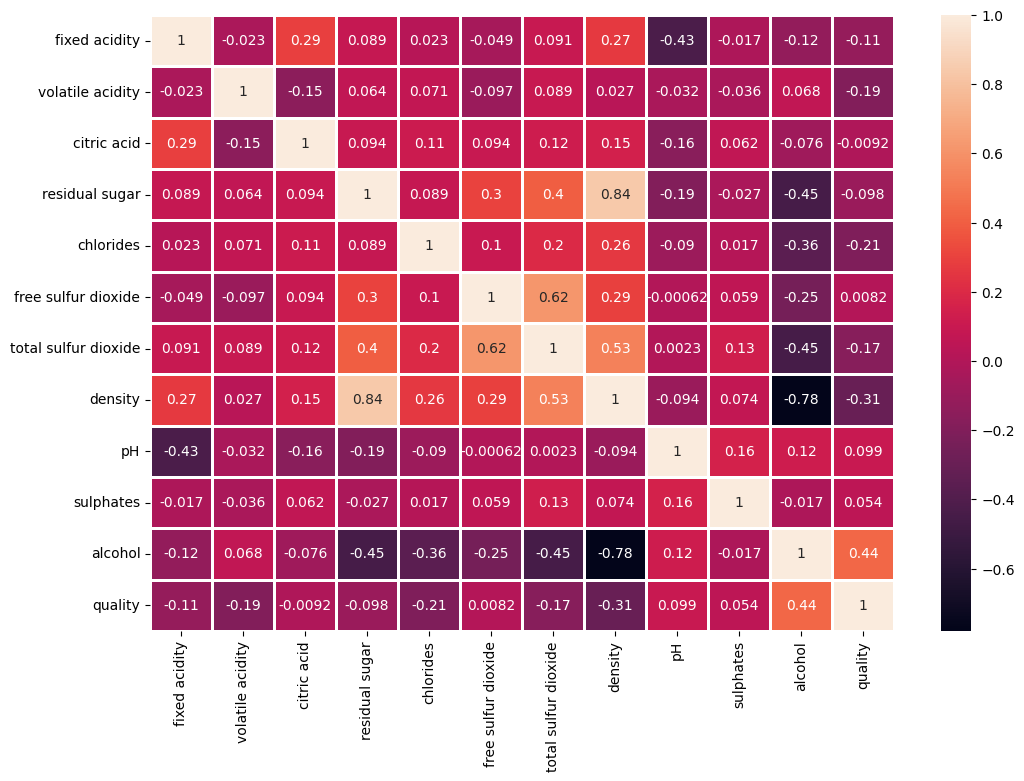

In [22]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, linewidths=1)

- Наблюдается существенная корреляция признака _alcohol_ c большей частью остальных признаков и главное - с целевым признаком _quality_ !!!
Считаю целесообразным удалить данный признак из набора данных

In [71]:
# Удалить признак alcohol
df.drop(['alcohol'], axis=1, inplace=True)

Визуализировать аномальные значения признаков

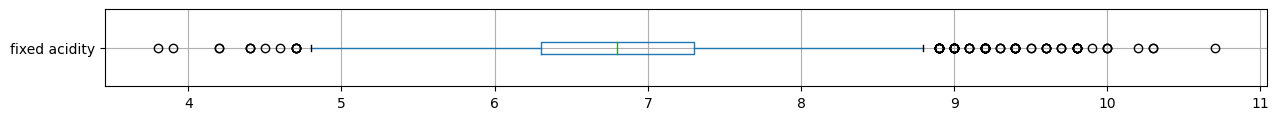

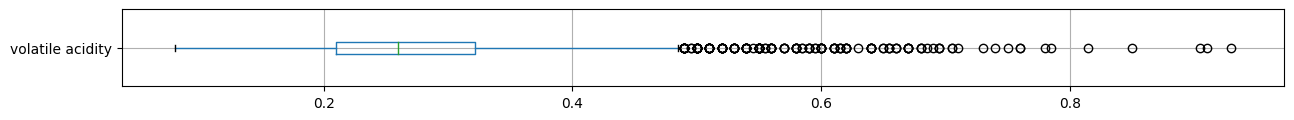

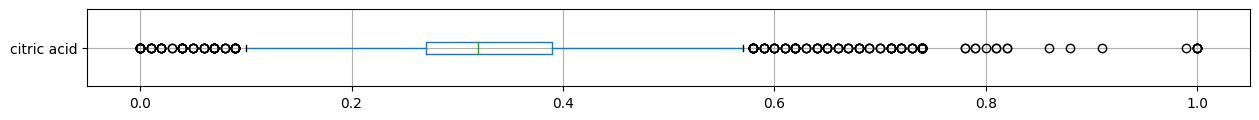

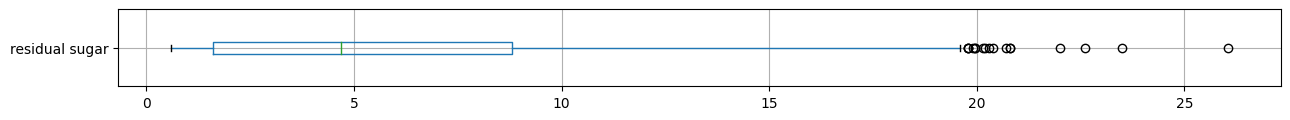

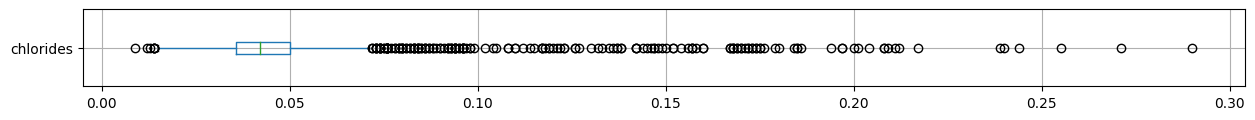

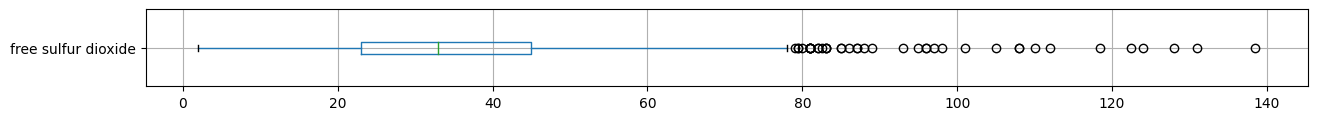

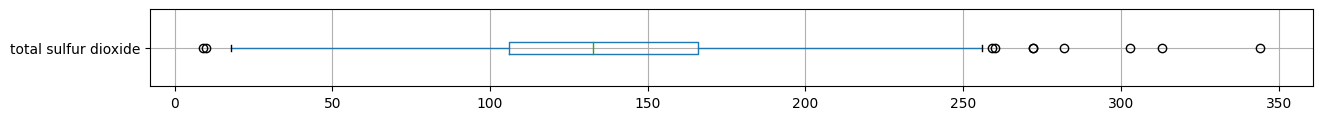

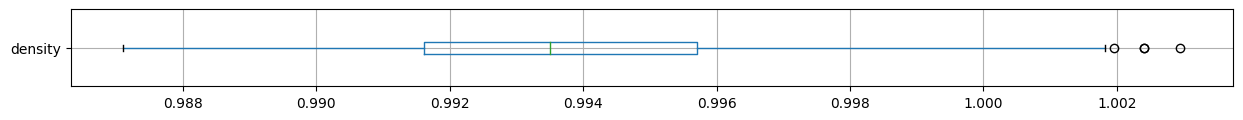

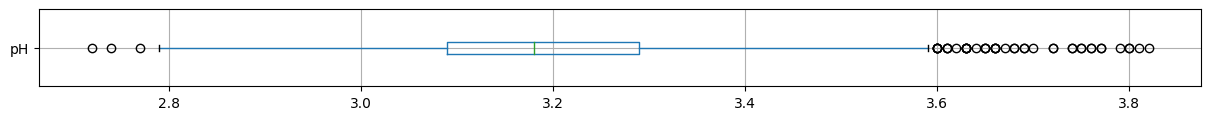

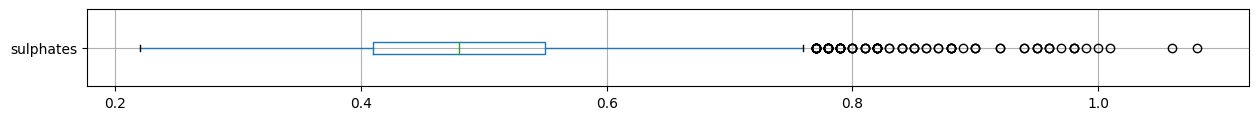

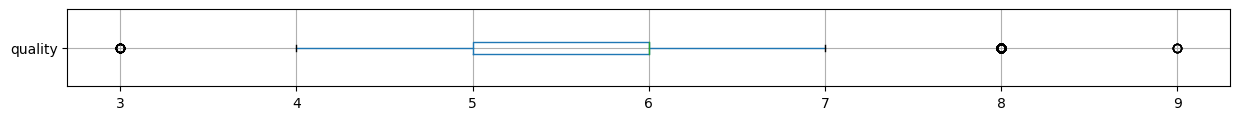

In [35]:
for col in df.columns:
    plt.figure(figsize=(15, 1))
    df[[col]].boxplot(vert=0 )

In [43]:
# Визуализировать распределение значений признаков
df.describe(include = "all").T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3948.0,6.834334,0.853986,3.80000,6.300000,6.8000,7.30000,10.70000
volatile acidity,3948.0,0.279782,0.101241,0.08000,0.210000,0.2600,0.32125,0.93000
citric acid,3948.0,0.333721,0.119794,0.00000,0.270000,0.3200,0.39000,1.00000
residual sugar,3948.0,5.893452,4.751334,0.60000,1.600000,4.7000,8.80000,26.05000
chlorides,3948.0,0.045770,0.022263,0.00900,0.035750,0.0420,0.05000,0.29000
free sulfur dioxide,3948.0,34.803445,16.630704,2.00000,23.000000,33.0000,45.00000,138.50000
total sulfur dioxide,3948.0,136.923379,42.564302,9.00000,106.000000,132.5000,166.00000,344.00000
density,3948.0,0.993772,0.002800,0.98711,0.991607,0.9935,0.99570,1.00295
pH,3948.0,3.195537,0.151495,2.72000,3.090000,3.1800,3.29000,3.82000
sulphates,3948.0,0.490243,0.113564,0.22000,0.410000,0.4800,0.55000,1.08000


In [72]:
# Удалить записи с максимальными значениями выбросов
df.drop(df[df['fixed acidity'] > 11].index, inplace=True)
df.drop(df[df['volatile acidity'] > 1].index, inplace=True)
df.drop(df[df['citric acid'] > 1.2].index, inplace=True)
df.drop(df[df['residual sugar'] > 30].index, inplace=True)
df.drop(df[df['chlorides'] > 0.3].index, inplace=True)
df.drop(df[df['free sulfur dioxide'] > 140].index, inplace=True)
df.drop(df[df['total sulfur dioxide'] > 350].index, inplace=True)
df.drop(df[df['density'] > 1.005].index, inplace=True)

Выполнить скалирование данных. Подготовьте данные для обучения

In [ ]:
df.hist(bins=100, figsize=(10,10))

In [101]:
#scaler = MinMaxScaler()
scaler = StandardScaler()

X = df.drop('quality', axis=1)
y = df['quality']

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### CatBoostClassifier

In [102]:
from catboost import CatBoostClassifier

cgb = CatBoostClassifier(verbose=False)
cgb.fit(X_train, y_train)

lb = LabelBinarizer()

In [103]:
y_pred_train = cgb.predict(X_train)

lb.fit(y_train)
print('AUC на обучающей выборке: {:.3f}'
    .format(metrics.roc_auc_score(lb.transform(y_train), lb.transform(y_pred_train), average='macro')))
print('Значения метрик для обучающей выборки:')
print(metrics.classification_report(y_train,y_pred_train))

AUC на обучающей выборке: 0.990
Значения метрик для обучающей выборки:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00       112
           5       0.98      0.98      0.98       874
           6       0.97      0.99      0.98      1334
           7       0.99      0.96      0.97       522
           8       1.00      0.98      0.99       103
           9       1.00      1.00      1.00         5

    accuracy                           0.98      2961
   macro avg       0.99      0.99      0.99      2961
weighted avg       0.98      0.98      0.98      2961



In [104]:
y_pred_test = cgb.predict(X_test)

lb.fit(y_test)
print('AUC на обучающей выборке: {:.3f}'
    .format(metrics.roc_auc_score(lb.transform(y_test), lb.transform(y_pred_test), average='macro')))
print('Значения метрик для тестовой выборки:')
print(metrics.classification_report(y_test,y_pred_test))

AUC на обучающей выборке: 0.584
Значения метрик для тестовой выборки:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.43      0.08      0.13        39
           5       0.55      0.57      0.56       299
           6       0.54      0.66      0.60       449
           7       0.56      0.40      0.46       167
           8       0.12      0.04      0.06        28

    accuracy                           0.55       987
   macro avg       0.37      0.29      0.30       987
weighted avg       0.53      0.55      0.53       987



c:\Program Files\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
